In [1]:
from utils import ModelImporter, Preprocessing
import torch
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# Analize Model with the Public Test Data

In [3]:
#load data
pre = Preprocessing('fer2013')
pre.load_data(filename='test_public_norm.csv', name='test')

X_df = pre.get(name='test').drop(columns=['emotion'])
y_df = pre.get(name='test')['emotion']

In [4]:
dtype = torch.float
device = torch.device("cpu")

n_classes = 7
n_epochs = 300
learning_rate = 0.0001
batch_size = 32

#epoch_n = 250# optimized to val loss
epoch_n=270# opmitized according to F1 score and val acc

model_name = f'cnn_double_layer_D_bs_{learning_rate}_{batch_size}_{n_epochs}_{n_classes}_epoch{epoch_n}'

m_importer = ModelImporter('fer2013_DatasetD')

model = m_importer.load_nn_model(model_name)

['cnn_double_layer_balanced_sampling_exp_c1_rot_0.0001_32_300_7_epoch270', 1, 7, [48, 48], 10, 15, 2]
load model CnnDoubleLayer(
  (drop_hidden): Dropout(p=0.5)
  (drop_visible): Dropout(p=0.2)
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=7, bias=True)
)


In [5]:
X_test = model.reshape_data(torch.tensor(X_df.values, device=device, dtype=dtype))
y_test = torch.tensor(y_df.values, device=device, dtype=torch.long)

In [6]:
y_pred_prob = model(X_test)

In [7]:
y_pred = y_pred_prob.argmax(1)

In [8]:
accuracy_soft = (y_pred == y_test).float().mean()
accuracy_soft

tensor(0.5428)

In [9]:
labels_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
labels_num = [0, 1, 2, 3, 4, 5, 6]
cm = metrics.confusion_matrix(y_test, y_pred, labels_num)
cm

array([[198,  10,  36,  36,  87,  26,  74],
       [ 10,  29,   2,   1,  10,   0,   4],
       [ 59,  10, 138,  23, 133,  59,  74],
       [ 41,   6,  14, 639,  65,  32,  98],
       [ 81,   8,  60,  36, 310,  20, 138],
       [ 14,   3,  27,  16,  20, 318,  17],
       [ 56,   1,  35,  42, 135,  22, 316]])

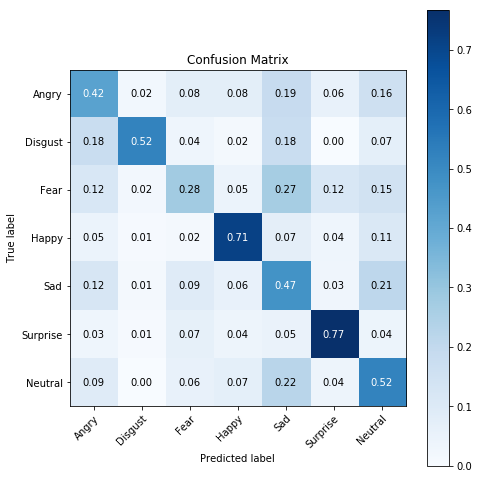

In [10]:
#visualize normalized confusion Matrix
np.set_printoptions(precision=2)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()